In [141]:
import pandas as pd
import numpy as np

import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Embedding, SpatialDropout1D, LSTM, GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from keras.layers import Dense, Activation, Dropout
# import LabelEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from matplotlib import pyplot as plt

from imblearn.over_sampling import SMOTE
from collections import Counter

from sklearn.metrics import classification_report, confusion_matrix
#test train split
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from collections import Counter




In [142]:
df = pd.read_csv('cleaned_dataset.csv')
df.columns

Index(['type', 'posts', 'cleaned_posts'], dtype='object')

In [143]:
def graph_plots(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.savefig(string + '.png')
  plt.show()

In [157]:
tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(df['cleaned_posts'])
tokenizer.word_index # Get our learned vocabulary
word_index = tokenizer.word_index

VOCAB_SIZE = len(word_index)+1 # Total words
print(VOCAB_SIZE)

135303


In [158]:
X = tokenizer.texts_to_sequences(df['cleaned_posts'])
MAX_SEQ_LENGTH = max(len(seq) for seq in X)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen= MAX_SEQ_LENGTH, padding = 'post') # Pad the sequence to the same length to make it uniform

In [159]:
from gensim.models import Word2Vec, KeyedVectors

gn_vec_zip_path ="/Users/salmazainana/Downloads/GoogleNews-vectors-negative300.bin"
model = KeyedVectors.load_word2vec_format(gn_vec_zip_path, binary=True)


In [160]:
word2vec_model = model

In [161]:
embedding_size = 300
embedding_matrix = np.zeros((VOCAB_SIZE, embedding_size))
for word, i in tokenizer.word_index.items():
    if word in word2vec_model:  # Use word2vec_model directly instead of word2vec_model.wv
        embedding_vector = word2vec_model[word]  # Same here
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [162]:
y = df['type']

#one hote encode the target variable such that ENTJ = [1,0,0,0], INTJ = [0,0,0,0], ENTP = [1,0,0,1], ect 
#dichotomy classification

# strip letter from the type so ['ENTJ'] becomes ['E','N','T','J']
y_stripped = y.apply(lambda x: list(x.strip()))

def preprocessing(y):
    if y[0] == 'E':
        y[0] = 1
    else:
        y[0] = 0
    if y[1] == 'N':
        y[1] = 1
    else:
        y[1] = 0
    if y[2] == 'T':
        y[2] = 1
    else:
        y[2] = 0
    if y[3] == 'J':
        y[3] = 1
    else:
        y[3] = 0

    return y 

y = y_stripped.apply(preprocessing)
y = np.array(y.tolist())
type(y)


numpy.ndarray

In [67]:
# model_path = "/Users/zainanasalma/Desktop/stanford/courses/CS229/mbti-cs229/Word2vec_model.model"
# #load model from model_path
# word2vec_model = tf.keras.models.load_model(model_path)

embedding_size = 100
# embedding_matrix = np.zeros((VOCAB_SIZE, embedding_size))

# for word, i in tokenizer.word_index.items():
#     if word in word2vec_model.wv:
#         embedding_vector = word2vec_model.wv[word]
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector




In [91]:
rate = 0.8
n_classes=4

model = Sequential()
#model.add(Embedding(VOCAB_SIZE, embedding_size, input_length=MAX_SEQ_LENGTH, weights=[embedding_matrix], trainable=False))
model.add(Embedding(VOCAB_SIZE, embedding_size, input_length=MAX_SEQ_LENGTH, trainable=False))
model.add(SimpleRNN(100))
model.add(Dropout(rate))
model.add(Dense(n_classes, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 957, 300)          40590900  
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 100)               40100     
                                                                 
 dropout_3 (Dropout)         (None, 100)               0         
                                                                 
 dense_7 (Dense)             (None, 4)                 404       
                                                                 
Total params: 40631404 (155.00 MB)
Trainable params: 40504 (158.22 KB)
Non-trainable params: 40590900 (154.84 MB)
_________________________________________________________________


In [92]:

#Train model 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train, 
          epochs=10, 
          batch_size=64, 
          validation_data=(X_test, y_test), 
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/10
109/109 [==============================] - 51s 467ms/step - loss: 0.6092 - accuracy: 0.6277 - val_loss: 0.5754 - val_accuracy: 0.6594
Epoch 2/10
109/109 [==============================] - 45s 410ms/step - loss: 0.5910 - accuracy: 0.6559 - val_loss: 0.5737 - val_accuracy: 0.6594
Epoch 3/10
109/109 [==============================] - 45s 412ms/step - loss: 0.5875 - accuracy: 0.6561 - val_loss: 0.5750 - val_accuracy: 0.6594
Epoch 4/10
109/109 [==============================] - 44s 406ms/step - loss: 0.5868 - accuracy: 0.6561 - val_loss: 0.5734 - val_accuracy: 0.6594
Epoch 5/10
109/109 [==============================] - 42s 383ms/step - loss: 0.5844 - accuracy: 0.6561 - val_loss: 0.5746 - val_accuracy: 0.6594
Epoch 6/10
109/109 [==============================] - 48s 437ms/step - loss: 0.5848 - accuracy: 0.6561 - val_loss: 0.5743 - val_accuracy: 0.6594
Epoch 7/10
109/109 [==============================] - 38s 346ms/step - loss: 0.5835 - accuracy: 0.6561 - val_loss: 0.5752 - val_ac

In [86]:

#save model as 4class rnn model
model_path = "4class_w2v_model.model"
model.save(model_path)

model = tf.keras.models.load_model("/Users/salmazainana/mbti-cs229/4class_w2v_model.model")


INFO:tensorflow:Assets written to: 4class_w2v_model.model/assets


INFO:tensorflow:Assets written to: 4class_w2v_model.model/assets


55/55 [==============================] - 20s 361ms/step
AUC for task 0: 0.5
AUC for task 1: 0.5
AUC for task 2: 0.5
AUC for task 3: 0.5


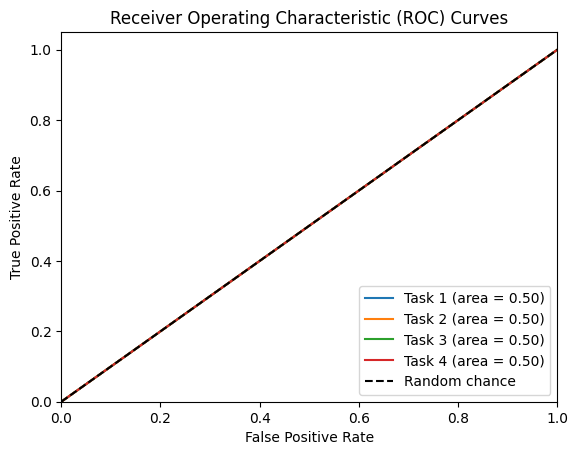

Average AUC: 0.5


In [88]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_pred = model.predict(X_test)
n_classes = y_test.shape[1]  # Make sure n_classes is defined

# Calculate AUC for each binary classification task and plot ROC curves
auc_scores = []

for i in range(n_classes):
    score = roc_auc_score(y_test[:, i], y_pred[:, i])  # Use a different variable name
    auc_scores.append(score)
    print(f"AUC for task {i}: {score}")

    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)  
    plt.plot(fpr, tpr, label=f'Task {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Calculate the average AUC across all tasks
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")


#one LSTM for 4binary class

In [72]:
#One LSTM 

model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_size, weights=[embedding_matrix], input_length=MAX_SEQ_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.8))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(4, activation='sigmoid'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


In [73]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 957, 300)          40590900  
                                                                 
 spatial_dropout1d_3 (Spati  (None, 957, 300)          0         
 alDropout1D)                                                    
                                                                 
 lstm_3 (LSTM)               (None, 100)               160400    
                                                                 
 dense_5 (Dense)             (None, 4)                 404       
                                                                 
Total params: 40751704 (155.46 MB)
Trainable params: 160804 (628.14 KB)
Non-trainable params: 40590900 (154.84 MB)
_________________________________________________________________


In [75]:
#Train model 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
history = model.fit(X_train, y_train, 
          epochs=30, 
          batch_size=64, 
          validation_data=(X_test, y_test), 
          callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/30
109/109 [==============================] - 353s 3s/step - loss: 2.8151 - accuracy: 0.6561 - val_loss: 2.6855 - val_accuracy: 0.6594
Epoch 2/30
109/109 [==============================] - 343s 3s/step - loss: 2.7699 - accuracy: 0.6561 - val_loss: 2.7024 - val_accuracy: 0.6594
Epoch 3/30
109/109 [==============================] - 358s 3s/step - loss: 2.7770 - accuracy: 0.6561 - val_loss: 2.7101 - val_accuracy: 0.6594
Epoch 4/30
109/109 [==============================] - 339s 3s/step - loss: 2.7866 - accuracy: 0.6561 - val_loss: 2.7230 - val_accuracy: 0.6594


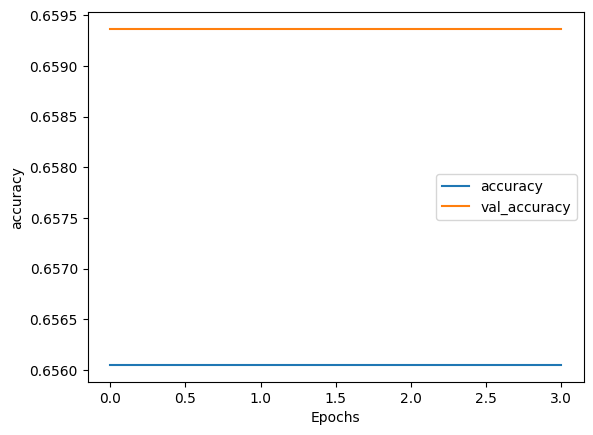

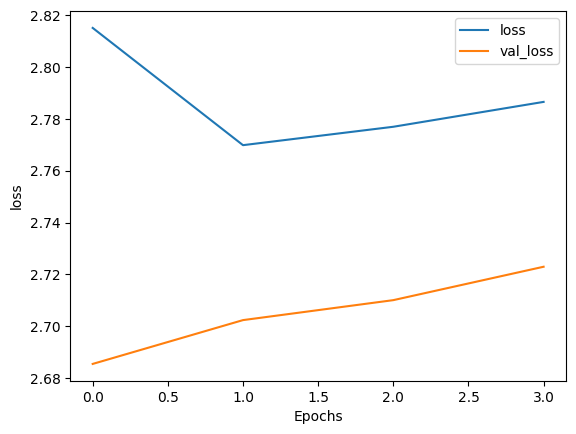

In [93]:
graph_plots(history, "accuracy")
graph_plots(history, "loss")

In [94]:
#save model as 4class rnn model
model_path = "4class_lstm_model.model"
model.save(model_path)


INFO:tensorflow:Assets written to: 4class_lstm_model.model/assets


INFO:tensorflow:Assets written to: 4class_lstm_model.model/assets


55/55 [==============================] - 4s 63ms/step
AUC for task 0: 0.4986707839472493
AUC for task 1: 0.4944853041545862
AUC for task 2: 0.47968640919267225
AUC for task 3: 0.4999971955566399


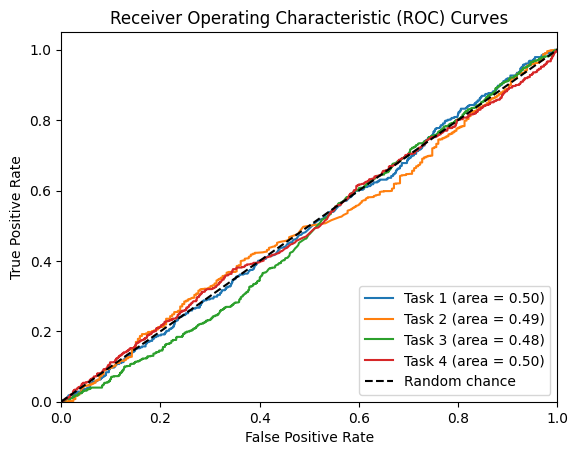

Average AUC: 0.4932099232127869


In [95]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_pred = model.predict(X_test)
n_classes = y_test.shape[1]  # Make sure n_classes is defined

# Calculate AUC for each binary classification task and plot ROC curves
auc_scores = []

for i in range(n_classes):
    score = roc_auc_score(y_test[:, i], y_pred[:, i])  # Use a different variable name
    auc_scores.append(score)
    print(f"AUC for task {i}: {score}")

    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)  
    plt.plot(fpr, tpr, label=f'Task {i+1} (area = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Calculate the average AUC across all tasks
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Assuming VOCAB_SIZE, embedding_size, embedding_matrix, and MAX_SEQ_LENGTH are defined elsewhere
model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_size, weights=[embedding_matrix], input_length=MAX_SEQ_LENGTH, trainable=False))
model.add(SpatialDropout1D(0.8))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2, kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01)))
model.add(Dense(4, activation='sigmoid', kernel_regularizer=l2(0.01)))

# Compile the model with binary_crossentropy
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')

# Train the model with validation split and callbacks
# Assuming X_train, y_train are defined and properly preprocessed
history = model.fit(X_train, y_train, validation_split=0.2, epochs=30, batch_size=128, callbacks=[early_stopping, model_checkpoint])


In [ ]:
model.summary()

In [ ]:
graph_plots(history, "accuracy")
graph_plots(history, "loss")

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_pred = model.predict(X_test)
n_classes = y_test.shape[1]  # Make sure n_classes is defined

# Calculate AUC for each binary classification task and plot ROC curves
auc_scores = []

for i in range(n_classes):
    score = roc_auc_score(y_test[:, i], y_pred[:, i])  # Use a different variable name
    auc_scores.append(score)
    print(f"AUC for task {i}: {score}")

    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)  
    plt.plot(fpr, tpr, label=f'Task {i+1} (area = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Calculate the average AUC across all tasks
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")



##### if no overfitting find good threshhold

In [98]:
def find_best_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # Calculate the J statistic for each threshold
    J = tpr - fpr
    # Find the index of the maximum J statistic
    index_of_max_J = np.argmax(J)
    best_threshold = thresholds[index_of_max_J]
    return best_threshold, J[index_of_max_J]

#best_threshold= np.zeros(n_classes)
for i in range(n_classes):
    best_threshold, max_J = find_best_threshold(y_test[:, i], y_pred[:, i])
    print(f"Best threshold for task {i}: {best_threshold} with J statistic: {max_J}")


Best threshold for task 0: 0.2570679783821106 with J statistic: 0.02684358590373148
Best threshold for task 1: 0.8321021795272827 with J statistic: 0.03922532173609178
Best threshold for task 2: 0.4751480519771576 with J statistic: 0.018274073657997714
Best threshold for task 3: 0.4147707521915436 with J statistic: 0.030527768195929617


#use these threshold to find accuracy :

In [130]:
best_threshold = [0.2570679783821106, 0.8321021795272827, 0.4751480519771576, 0.4147707521915436]  # Replace with the best thresholds for each task
#score accuracy
for i in range(n_classes):
    # return 1 if y_pred[i] > best_threshold[i], else 0
    if i == 2: 
        y_pred[:, i] = (y_pred[:, i] < best_threshold[i]).astype(int)
    else :
        y_pred[:, i] = (y_pred[:, i] > best_threshold[i]).astype(int)
    
    print(f"Accuracy for task {i}: {accuracy_score(y_test[:, i], y_pred[:, i])}")

Accuracy for task 0: 0.7798270893371758
Accuracy for task 1: 0.14178674351585013
Accuracy for task 2: 0.5400576368876081
Accuracy for task 3: 0.6144092219020173


In [163]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



ValueError: Imbalanced-learn currently supports binary, multiclass and binarized encoded multiclasss targets. Multilabel and multioutput targets are not supported.

In [133]:
model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_size, weights=[embedding_matrix], input_length=MAX_SEQ_LENGTH, trainable=False))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.8))

model.add(LSTM(256, return_sequences=True))
model.add(Dropout(0.8))

model.add(LSTM(256))
model.add(Dropout(0.8))

model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='softmax'))

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])

In [134]:
history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=30, 
                    batch_size=128,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                              patience=10,
                                                verbose=1, 
                                                mode='min')])

Epoch 1/30
44/44 [==============================] - 294s 7s/step - loss: 0.3012 - accuracy: 0.0283 - val_loss: 0.2936 - val_accuracy: 0.0195
Epoch 2/30
44/44 [==============================] - 292s 7s/step - loss: 0.2932 - accuracy: 0.0459 - val_loss: 0.2855 - val_accuracy: 0.0195
Epoch 3/30
44/44 [==============================] - 293s 7s/step - loss: 0.2845 - accuracy: 0.4164 - val_loss: 0.2755 - val_accuracy: 0.6513
Epoch 4/30
44/44 [==============================] - 297s 7s/step - loss: 0.2739 - accuracy: 0.6571 - val_loss: 0.2632 - val_accuracy: 0.6513
Epoch 5/30
44/44 [==============================] - 296s 7s/step - loss: 0.2618 - accuracy: 0.6571 - val_loss: 0.2539 - val_accuracy: 0.6513
Epoch 6/30
44/44 [==============================] - 293s 7s/step - loss: 0.2570 - accuracy: 0.6572 - val_loss: 0.2514 - val_accuracy: 0.6513
Epoch 7/30
44/44 [==============================] - 291s 7s/step - loss: 0.2554 - accuracy: 0.6572 - val_loss: 0.2504 - val_accuracy: 0.6513
Epoch 8/30
44

55/55 [==============================] - 96s 2s/step
AUC for task 0: 0.48699806131807155
AUC for task 1: 0.5043776310832282
AUC for task 2: 0.5101788623105256
AUC for task 3: 0.49871486383025265


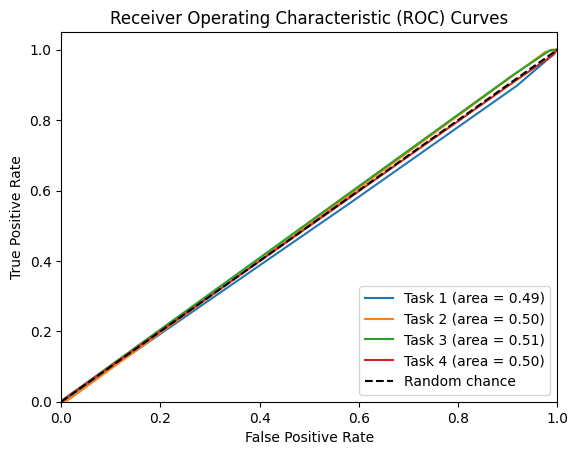

Average AUC: 0.5000673546355195


In [135]:
from sklearn.metrics import roc_auc_score, roc_curve, auc

y_pred = model.predict(X_test)
n_classes = y_test.shape[1]  # Make sure n_classes is defined

# Calculate AUC for each binary classification task and plot ROC curves
auc_scores = []

for i in range(n_classes):
    score = roc_auc_score(y_test[:, i], y_pred[:, i])  # Use a different variable name
    auc_scores.append(score)
    print(f"AUC for task {i}: {score}")

    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)  
    plt.plot(fpr, tpr, label=f'Task {i+1} (area = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")
plt.show()

# Calculate the average AUC across all tasks
average_auc = np.mean(auc_scores)
print(f"Average AUC: {average_auc}")

In [136]:
def find_best_threshold(y_true, y_scores):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    # Calculate the J statistic for each threshold
    J = tpr - fpr
    # Find the index of the maximum J statistic
    index_of_max_J = np.argmax(J)
    best_threshold = thresholds[index_of_max_J]
    return best_threshold, J[index_of_max_J]

best_threshold= np.zeros(n_classes)
for i in range(n_classes):
    best_threshold[i], max_J = find_best_threshold(y_test[:, i], y_pred[:, i])
    print(f"Best threshold for task {i}: {best_threshold} with J statistic: {max_J}")


Best threshold for task 0: [0.00125422 0.         0.         0.        ] with J statistic: 0.0037574054940930184
Best threshold for task 1: [0.00125422 0.61314064 0.         0.        ] with J statistic: 0.017674327179806437
Best threshold for task 2: [0.00125422 0.61314064 0.22336026 0.        ] with J statistic: 0.01747565284609609
Best threshold for task 3: [0.00125422 0.61314064 0.22336026 0.16224565] with J statistic: 0.002051450317883655


In [137]:
#score accuracy
for i in range(n_classes):
    # return 1 if y_pred[i] > best_threshold[i], else 0
    if i == 2: 
        y_pred[:, i] = (y_pred[:, i] < best_threshold[i]).astype(int)
    else :
        y_pred[:, i] = (y_pred[:, i] > best_threshold[i]).astype(int)
    
    print(f"Accuracy for task {i}: {accuracy_score(y_test[:, i], y_pred[:, i])}")

Accuracy for task 0: 0.7792507204610951
Accuracy for task 1: 0.145821325648415
Accuracy for task 2: 0.5244956772334294
Accuracy for task 3: 0.6144092219020173


In [138]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [148]:
from tensorflow.keras.layers import Bidirectional, LSTM


model = Sequential()
model.add(Embedding(VOCAB_SIZE, embedding_size, weights=[embedding_matrix], input_length=MAX_SEQ_LENGTH, trainable=False))
model.add(tf.keras.layers.Conv1D(32, (1), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv1D(32, (1), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) 

model.add(tf.keras.layers.Conv1D(64, (1), padding='same', activation='relu'))
model.add(tf.keras.layers.Conv1D(64, (1), activation='relu'))
model.add(tf.keras.layers.Dropout(0.5)) 

model.add(Bidirectional(LSTM(64)))
model.add(Dense(4, activation = 'sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['acc'])

history = model.fit(X_train, y_train, 
                    validation_split=0.2, 
                    epochs=30, 
                    batch_size=128,
                    callbacks=[EarlyStopping(monitor='val_loss',
                                              patience=10,
                                                verbose=1, 
                                                mode='min')])

Epoch 1/30
44/44 [==============================] - 54s 1s/step - loss: 3.0726 - acc: 0.6340 - val_loss: 2.9342 - val_acc: 0.6513
Epoch 2/30
44/44 [==============================] - 56s 1s/step - loss: 2.9086 - acc: 0.6572 - val_loss: 2.8907 - val_acc: 0.6513
Epoch 3/30
44/44 [==============================] - 46s 1s/step - loss: 2.9098 - acc: 0.6572 - val_loss: 2.7899 - val_acc: 0.6513
Epoch 4/30
44/44 [==============================] - 45s 1s/step - loss: 2.8928 - acc: 0.6572 - val_loss: 2.8873 - val_acc: 0.6513
Epoch 5/30
44/44 [==============================] - 52s 1s/step - loss: 2.9040 - acc: 0.6572 - val_loss: 2.8388 - val_acc: 0.6513
Epoch 6/30
44/44 [==============================] - 50s 1s/step - loss: 2.9103 - acc: 0.6572 - val_loss: 2.8117 - val_acc: 0.6513
Epoch 7/30
44/44 [==============================] - 43s 981ms/step - loss: 2.8865 - acc: 0.6572 - val_loss: 2.8185 - val_acc: 0.6513
Epoch 8/30
44/44 [==============================] - 48s 1s/step - loss: 2.8992 - acc: 0

In [ ]:
y_pred = model.predict(X_test)
n_classes = y_test.shape[1]  # Make sure n_classes is defined

# Calculate AUC for each binary classification task and plot ROC curves
auc_scores = []

for i in range(n_classes):
    score = roc_auc_score(y_test[:, i], y_pred[:, i])  # Use a different variable name
    auc_scores.append(score)
    # print(f"AUC for task {i}: {score}")

    fpr, tpr, thresholds = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc = auc(fpr, tpr)  
#     plt.plot(fpr, tpr, label=f'Task {i+1} (area = {roc_auc:.2f})')


# plt.plot([0, 1], [0, 1], 'k--', label='Random chance')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('False Positive Rate')
# plt.ylabel('True Positive Rate')
# plt.title('Receiver Operating Characteristic (ROC) Curves')
# plt.legend(loc="lower right")
# plt.show()

# # Calculate the average AUC across all tasks
# average_auc = np.mean(auc_scores)
# print(f"Average AUC: {average_auc}")

Best threshold for task 0: [0.0517122 0.        0.        0.       ] with J statistic: 0.0037574054940930184
Best threshold for task 1: [0.0517122  0.71878392 0.         0.        ] with J statistic: 0.0027218573058799267
Best threshold for task 2: [0.0517122  0.71878392        inf 0.        ] with J statistic: 0.0
Best threshold for task 3: [0.0517122  0.71878392        inf        inf] with J statistic: 0.0


In [154]:
#score accuracy
for i in range(n_classes):
    # return 1 if y_pred[i] > best_threshold[i], else 0
    
    y_pred[:, i] = (y_pred[:, i] > best_threshold[i]).astype(int)
    
    print(f"Accuracy for task {i}: {accuracy_score(y_test[:, i], y_pred[:, i])}")

Accuracy for task 0: 0.7804034582132565
Accuracy for task 1: 0.8570605187319885
Accuracy for task 2: 0.5400576368876081
Accuracy for task 3: 0.6144092219020173


In [156]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_26 (Embedding)    (None, 957, 300)          40590900  
                                                                 
 conv1d_16 (Conv1D)          (None, 957, 32)           9632      
                                                                 
 conv1d_17 (Conv1D)          (None, 957, 32)           1056      
                                                                 
 dropout_20 (Dropout)        (None, 957, 32)           0         
                                                                 
 conv1d_18 (Conv1D)          (None, 957, 64)           2112      
                                                                 
 conv1d_19 (Conv1D)          (None, 957, 64)           4160      
                                                                 
 dropout_21 (Dropout)        (None, 957, 64)         